## Описание проекта

Сервис по продаже автомобилей с пробегом «Не бит, не крашен» разрабатывает приложение для привлечения новых клиентов. В нём можно быстро узнать рыночную стоимость своего автомобиля. В вашем распоряжении исторические данные: технические характеристики, комплектации и цены автомобилей. Вам нужно построить модель для определения стоимости. 

Заказчику важны:

- качество предсказания;
- скорость предсказания;
- время обучения.

Постройте модель, которая умеет её определять. В вашем распоряжении данные о технических характеристиках, комплектации и ценах других автомобилей.

**Признаки**
- DateCrawled — дата скачивания анкеты из базы
- VehicleType — тип автомобильного кузова
- RegistrationYear — год регистрации автомобиля
- Gearbox — тип коробки передач
- Power — мощность (л. с.)
- Model — модель автомобиля
- Kilometer — пробег (км)
- RegistrationMonth — месяц регистрации автомобиля
- FuelType — тип топлива
- Brand — марка автомобиля
- Repaired — была машина в ремонте или нет
- DateCreated — дата создания анкеты
- NumberOfPictures — количество фотографий автомобиля
- PostalCode — почтовый индекс владельца анкеты (пользователя)
- LastSeen — дата последней активности пользователя  

**Целевой признак**
- Price — цена (евро)

## Необходимые библиотеки и паеременные 

In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler 
from catboost import CatBoostClassifier
from notifiers import get_notifier
from sklearn.ensemble import RandomForestRegressor as RFR
from sklearn.metrics import mean_squared_error as MSE
from time import time
from sklearn.linear_model import LinearRegression as LR
from catboost import CatBoostRegressor as CBR

In [2]:
def make_notifier(
    token='5658096333:AAHiwKbKFkFDhJH-0eSKwDeXmJnYsqXc88A',
    chat_id=-831532630):
    def f(text):
        notifier = get_notifier('telegram')
        notifier.notify(
            message=text,
            token=token,
            chat_id=chat_id)
    return f

In [3]:
bot_send = make_notifier()

In [4]:
RANDOM_STATE = 846513

## Выгрузка данных

In [5]:
df = pd.read_csv('./autos.csv')

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   DateCrawled        354369 non-null  object
 1   Price              354369 non-null  int64 
 2   VehicleType        316879 non-null  object
 3   RegistrationYear   354369 non-null  int64 
 4   Gearbox            334536 non-null  object
 5   Power              354369 non-null  int64 
 6   Model              334664 non-null  object
 7   Kilometer          354369 non-null  int64 
 8   RegistrationMonth  354369 non-null  int64 
 9   FuelType           321474 non-null  object
 10  Brand              354369 non-null  object
 11  Repaired           283215 non-null  object
 12  DateCreated        354369 non-null  object
 13  NumberOfPictures   354369 non-null  int64 
 14  PostalCode         354369 non-null  int64 
 15  LastSeen           354369 non-null  object
dtypes: int64(7), object(

In [7]:
df.sample(5, random_state = RANDOM_STATE)

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
104963,2016-03-31 10:06:37,2000,suv,2006,auto,140,sorento,150000,1,gasoline,kia,no,2016-03-31 00:00:00,0,57234,2016-04-05 19:15:42
210388,2016-03-17 13:53:07,995,NaN,2017,manual,75,clio,100000,4,NaN,renault,no,2016-03-17 00:00:00,0,94151,2016-03-21 17:49:20
47608,2016-03-09 18:46:51,750,small,2004,manual,69,corsa,150000,7,gasoline,opel,yes,2016-03-09 00:00:00,0,73037,2016-03-09 18:46:51
134122,2016-03-27 18:25:18,15,NaN,2005,NaN,0,a4,125000,0,NaN,audi,NaN,2016-03-27 00:00:00,0,56332,2016-04-05 23:17:51
290723,2016-03-31 21:36:35,2950,sedan,2003,manual,147,vectra,150000,3,petrol,opel,no,2016-03-31 00:00:00,0,24943,2016-04-06 16:45:23


По таблицам видно, что в данных присутствуют проблемы:
1. Есть пропуски
2. Не все столбцы имеют оптимальный формат
3. Как видно строка №134122 содержит автомобиль в которм практически нет информации, такие строки тоже нужно обработать.

## Подготовка данных

### Проверка связей

Прежде чем заниматься столбцами нужно посмотреть как они связаны. Построим таблицу корреляций.

In [8]:
df_corr = df.corr()

In [9]:
df_corr.style.background_gradient(axis=0,
                                  vmin=df_corr.min().min(),
                                  vmax=df_corr.max().max(),
                                  text_color_threshold=0)

,Price,RegistrationYear,Power,Kilometer,RegistrationMonth,NumberOfPictures,PostalCode
Price,1.000000,0.026916,0.158872,-0.333199,0.110581,nan,0.076055
RegistrationYear,0.026916,1.000000,-0.000828,-0.053447,-0.011619,nan,-0.003459
Power,0.158872,-0.000828,1.000000,0.024002,0.043380,nan,0.021665
Kilometer,-0.333199,-0.053447,0.024002,1.000000,0.009571,nan,-0.007698
RegistrationMonth,0.110581,-0.011619,0.043380,0.009571,1.000000,nan,0.013995
NumberOfPictures,nan,nan,nan,nan,nan,nan,nan
PostalCode,0.076055,-0.003459,0.021665,-0.007698,0.013995,nan,1.000000


Как видно из таблицы, цена немного зависти от всего, но больше всего от пробега и мощности машины, все как в жизни. НА счет категориальных признаков покачто ничего сказать нельзя, позже посмотрим и на них.

### Проверка на дубликаты.

Посмотрим на прнисутствие явных дубликатов.

In [10]:
df.duplicated().sum()

4

Есть 4 штуки, возможно есть еще, попробуем убрать цену и дату последней активности, тк человек мог ошибиться с ценой и пересозадть объявление.

In [11]:
df.drop(['Price', 'LastSeen'],axis=1).duplicated().sum()

21

21 объявление, уже лучше

Уберем их

In [12]:
col = list(df.columns)
col.remove('Price')
col.remove('LastSeen')
col

['DateCrawled',
 'VehicleType',
 'RegistrationYear',
 'Gearbox',
 'Power',
 'Model',
 'Kilometer',
 'RegistrationMonth',
 'FuelType',
 'Brand',
 'Repaired',
 'DateCreated',
 'NumberOfPictures',
 'PostalCode']

In [13]:
df = df.drop_duplicates(subset = col).reset_index(drop=True)

In [14]:
df.drop(['Price', 'LastSeen'],axis=1).duplicated().sum()

0

Стало немного лучше.

### Столбцы

Для начала посмотрим на каждый столбец по отдлеьности и выявим их проблемы.

#### DateCrawled

По скольку в данном столбце нет пропусков. Первое что хочется сделать с данным столбцом, это перевсти его в формат даты.

In [15]:
df['DateCrawled'] = pd.to_datetime(df['DateCrawled'], format = '%Y-%m-%d %H:%M:%S')

In [16]:
df['DateCrawled'].sample(5)

29885    2016-03-12 21:52:45
348659   2016-03-29 20:54:58
112371   2016-03-11 18:48:27
160327   2016-03-12 12:49:17
80059    2016-03-29 21:50:41
Name: DateCrawled, dtype: datetime64[ns]

Отлично, думаю с данным столбцом закончели, скорее всего от него будут созданы дополнительные столбцы, но это чуть позже.

#### Price

Это стобце с целевым признаком, в нем нет пропусков уже хорошо. Можно просто посмотреть как распределены в нем цены.

<AxesSubplot:>

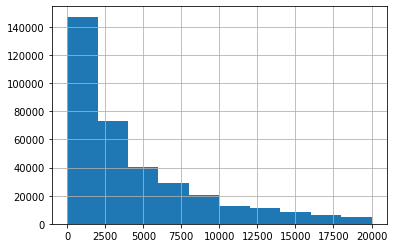

In [17]:
df['Price'].hist()

По скольку цены ограничены 0 то мы видем чать нормального распредшления. По этому можно сдлеать вывод, что данных достатчоно и они имеют хорошие значнения для обучения.

Неплохо бы еще посмотреть объявления с 0 цеником.

In [18]:
len(df.loc[df['Price'] == 0])

10772

In [19]:
df.loc[df['Price'] == 0].sample(5, random_state = RANDOM_STATE)

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
327795,2016-03-26 15:52:30,0,sedan,2003,auto,177,e_klasse,150000,10,petrol,mercedes_benz,no,2016-03-26 00:00:00,0,95100,2016-04-06 04:15:46
266479,2016-03-05 22:45:26,0,other,1997,manual,131,other,50000,9,petrol,fiat,yes,2016-03-05 00:00:00,0,50733,2016-03-08 12:17:09
106022,2016-04-02 14:50:26,0,coupe,2000,manual,133,other,150000,4,petrol,chrysler,no,2016-04-02 00:00:00,0,68309,2016-04-06 13:17:41
32515,2016-03-20 22:47:53,0,bus,2004,manual,0,zafira,150000,0,cng,opel,NaN,2016-03-20 00:00:00,0,33615,2016-04-07 09:17:40
331230,2016-03-21 20:46:44,0,NaN,2005,manual,0,NaN,5000,0,NaN,sonstige_autos,no,2016-03-21 00:00:00,0,15827,2016-04-02 23:16:03


Очень странные объявления с 0 ценой. Нужно думать что с нимим делать. После всех корректировок, создадим второй дата сет без нулевых цен и посмотрим на чем модель обучится лучше.

#### VehicleType

По скольку это тип кузова автомобиля, можно посмотреть на количество типов и их распредление. Так же в этом столбце есть пропуски, нужно их оценить.

In [20]:
df['VehicleType'].unique()

array([nan, 'coupe', 'suv', 'small', 'sedan', 'convertible', 'bus',
       'wagon', 'other'], dtype=object)

In [21]:
df['VehicleType'].isna().sum()

37490

In [22]:
f'сколько стостваляют пропуски: {(df["VehicleType"].isna().sum()/len(df)*100).round(2)}%'

'сколько стостваляют пропуски: 10.58%'

<AxesSubplot:ylabel='VehicleType'>

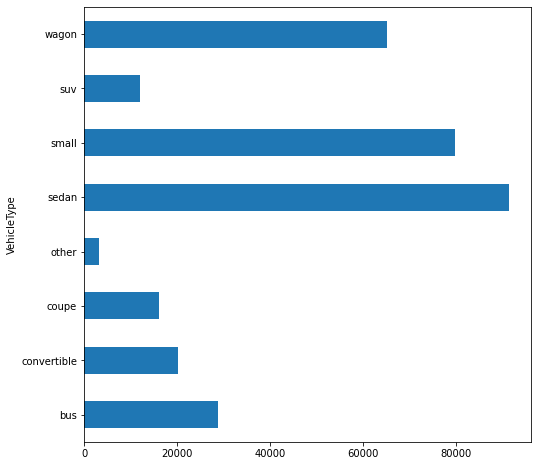

In [23]:
df.pivot_table(index = "VehicleType",
               values = "Price",
               aggfunc = "count").plot(y = "Price", 
                                      kind = "barh", 
                                      legend = False,
                                      figsize = (8,8),
                                      ylabel = "")

По скольку удаление столбцов с пропусками это достаточно большая потеря данных, почти 11%, по этому заменим все наны на категорию "unknow".

In [24]:
df['VehicleType'] = df['VehicleType'].fillna('unknow')

<AxesSubplot:ylabel='VehicleType'>

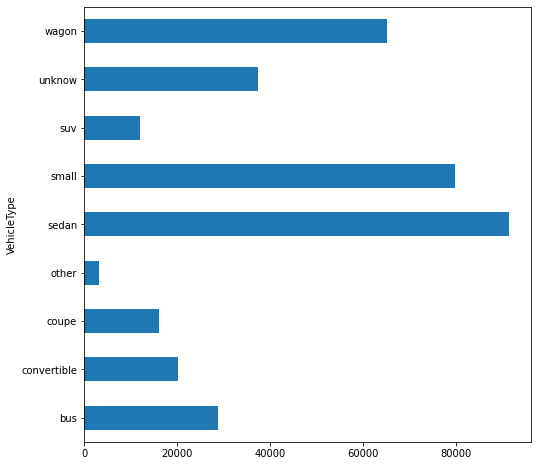

In [25]:
df.pivot_table(index = "VehicleType",
               values = "Price",
               aggfunc = "count").plot(y = "Price", 
                                      kind = "barh", 
                                      legend = False,
                                      figsize = (8,8),
                                      ylabel = "")

Отлично, можно двигаться к другому столбцу.

#### RegistrationYear

Тут пропусков нет, по этому просто посмотрим на рапределение по годам.

<AxesSubplot:>

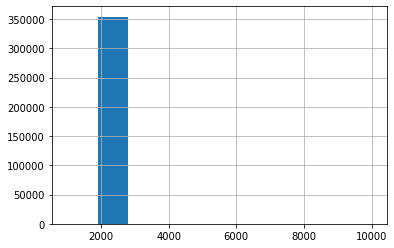

In [26]:
df['RegistrationYear'].hist()

по диаграмме видно, что есть какие-то значения выходящие за 3000 год, очевидно это выбросы. Посмторим сколько их и какие вообще етсь значения.

In [27]:
df['RegistrationYear'].sort_values().unique()

array([1000, 1001, 1039, 1111, 1200, 1234, 1253, 1255, 1300, 1400, 1500,
       1600, 1602, 1688, 1800, 1910, 1915, 1919, 1920, 1923, 1925, 1927,
       1928, 1929, 1930, 1931, 1932, 1933, 1934, 1935, 1936, 1937, 1938,
       1940, 1941, 1942, 1943, 1944, 1945, 1946, 1947, 1948, 1949, 1950,
       1951, 1952, 1953, 1954, 1955, 1956, 1957, 1958, 1959, 1960, 1961,
       1962, 1963, 1964, 1965, 1966, 1967, 1968, 1969, 1970, 1971, 1972,
       1973, 1974, 1975, 1976, 1977, 1978, 1979, 1980, 1981, 1982, 1983,
       1984, 1985, 1986, 1987, 1988, 1989, 1990, 1991, 1992, 1993, 1994,
       1995, 1996, 1997, 1998, 1999, 2000, 2001, 2002, 2003, 2004, 2005,
       2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016,
       2017, 2018, 2019, 2066, 2200, 2222, 2290, 2500, 2800, 2900, 3000,
       3200, 3500, 3700, 3800, 4000, 4100, 4500, 4800, 5000, 5300, 5555,
       5600, 5900, 5911, 6000, 6500, 7000, 7100, 7500, 7800, 8000, 8200,
       8455, 8500, 8888, 9000, 9229, 9450, 9996, 99

Разброс очень большой от 1000 года, до 9999. Вызвано скорее всего человеческим фатором. Для начла посмотри на строки раньше 1910 года.

In [28]:
df.loc[df['RegistrationYear'] < 1910]

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
622,2016-03-16 16:55:09,0,unknow,1111,NaN,0,NaN,5000,0,NaN,opel,NaN,2016-03-16 00:00:00,0,44628,2016-03-20 16:44:37
16062,2016-03-29 23:42:16,190,unknow,1000,NaN,0,mondeo,5000,0,NaN,ford,NaN,2016-03-29 00:00:00,0,47166,2016-04-06 10:44:58
18224,2016-03-09 17:49:44,7999,unknow,1500,manual,224,impreza,5000,3,NaN,subaru,NaN,2016-03-09 00:00:00,0,53577,2016-03-15 05:15:17
34332,2016-04-01 06:02:10,450,unknow,1800,NaN,1800,NaN,5000,2,NaN,mitsubishi,no,2016-04-01 00:00:00,0,63322,2016-04-01 09:42:30
38875,2016-03-19 23:54:40,1234,unknow,1234,NaN,26,NaN,5000,1,NaN,trabant,NaN,2016-03-19 00:00:00,0,38518,2016-04-06 03:15:22
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
323424,2016-03-26 20:58:27,30,unknow,1000,NaN,0,NaN,5000,0,NaN,audi,NaN,2016-03-26 00:00:00,0,37574,2016-04-06 12:17:27
325719,2016-03-30 11:36:35,400,unknow,1000,NaN,0,NaN,5000,0,NaN,mercedes_benz,NaN,2016-03-30 00:00:00,0,8060,2016-04-01 06:16:46
340739,2016-04-04 23:55:47,700,unknow,1600,manual,1600,a3,150000,4,petrol,audi,no,2016-04-04 00:00:00,0,86343,2016-04-05 06:44:07
348810,2016-03-22 00:38:15,1,unknow,1000,NaN,1000,NaN,150000,0,NaN,sonstige_autos,NaN,2016-03-21 00:00:00,0,41472,2016-04-05 14:18:01


Объявления достаточно "живые" можно предположить, что люди просто опечаталась или вводили две цифры при подаче объявления, а алгоритм дописал 00.

Тогда если объявление заканчиватеся на 00 то можно первые две цифры перенести в конец, остается определить к какому столетию будет относиться автомобиль, к 20 веку или 21. Можно это оценить по дате создания объявления.

In [29]:
def year_cor (df):
    if df['RegistrationYear']%100 == 0:
        if int(df['DateCreated'][2:4]) > df['RegistrationYear']//100:
            return 2000+df['RegistrationYear']//100
        else:
            return 1900+df['RegistrationYear']//100
    else:
        if int(df['DateCreated'][2:4]) > df['RegistrationYear']%100:
            return 2000+df['RegistrationYear']%100
        else:
            return 1900+df['RegistrationYear']%100

In [30]:
df.loc[df['RegistrationYear'] < 1910]

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
622,2016-03-16 16:55:09,0,unknow,1111,NaN,0,NaN,5000,0,NaN,opel,NaN,2016-03-16 00:00:00,0,44628,2016-03-20 16:44:37
16062,2016-03-29 23:42:16,190,unknow,1000,NaN,0,mondeo,5000,0,NaN,ford,NaN,2016-03-29 00:00:00,0,47166,2016-04-06 10:44:58
18224,2016-03-09 17:49:44,7999,unknow,1500,manual,224,impreza,5000,3,NaN,subaru,NaN,2016-03-09 00:00:00,0,53577,2016-03-15 05:15:17
34332,2016-04-01 06:02:10,450,unknow,1800,NaN,1800,NaN,5000,2,NaN,mitsubishi,no,2016-04-01 00:00:00,0,63322,2016-04-01 09:42:30
38875,2016-03-19 23:54:40,1234,unknow,1234,NaN,26,NaN,5000,1,NaN,trabant,NaN,2016-03-19 00:00:00,0,38518,2016-04-06 03:15:22
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
323424,2016-03-26 20:58:27,30,unknow,1000,NaN,0,NaN,5000,0,NaN,audi,NaN,2016-03-26 00:00:00,0,37574,2016-04-06 12:17:27
325719,2016-03-30 11:36:35,400,unknow,1000,NaN,0,NaN,5000,0,NaN,mercedes_benz,NaN,2016-03-30 00:00:00,0,8060,2016-04-01 06:16:46
340739,2016-04-04 23:55:47,700,unknow,1600,manual,1600,a3,150000,4,petrol,audi,no,2016-04-04 00:00:00,0,86343,2016-04-05 06:44:07
348810,2016-03-22 00:38:15,1,unknow,1000,NaN,1000,NaN,150000,0,NaN,sonstige_autos,NaN,2016-03-21 00:00:00,0,41472,2016-04-05 14:18:01


In [31]:
df.loc[df['RegistrationYear'] < 1910, 'RegistrationYear'] = df.loc[df['RegistrationYear'] < 1910].apply(year_cor, axis =1 )

In [32]:
df['RegistrationYear'].sort_values().unique()

array([1910, 1915, 1916, 1918, 1919, 1920, 1923, 1925, 1927, 1928, 1929,
       1930, 1931, 1932, 1933, 1934, 1935, 1936, 1937, 1938, 1939, 1940,
       1941, 1942, 1943, 1944, 1945, 1946, 1947, 1948, 1949, 1950, 1951,
       1952, 1953, 1954, 1955, 1956, 1957, 1958, 1959, 1960, 1961, 1962,
       1963, 1964, 1965, 1966, 1967, 1968, 1969, 1970, 1971, 1972, 1973,
       1974, 1975, 1976, 1977, 1978, 1979, 1980, 1981, 1982, 1983, 1984,
       1985, 1986, 1987, 1988, 1989, 1990, 1991, 1992, 1993, 1994, 1995,
       1996, 1997, 1998, 1999, 2000, 2001, 2002, 2003, 2004, 2005, 2006,
       2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017,
       2018, 2019, 2066, 2200, 2222, 2290, 2500, 2800, 2900, 3000, 3200,
       3500, 3700, 3800, 4000, 4100, 4500, 4800, 5000, 5300, 5555, 5600,
       5900, 5911, 6000, 6500, 7000, 7100, 7500, 7800, 8000, 8200, 8455,
       8500, 8888, 9000, 9229, 9450, 9996, 9999], dtype=int64)

По такойже системе можно и откорректировать года больше 2019

In [33]:
df.loc[df['RegistrationYear'] > 2019, 'RegistrationYear'] = df.loc[df['RegistrationYear'] > 2019].apply(year_cor, axis =1 )

In [34]:
df['RegistrationYear'].sort_values().unique()

array([1910, 1915, 1916, 1918, 1919, 1920, 1922, 1923, 1925, 1927, 1928,
       1929, 1930, 1931, 1932, 1933, 1934, 1935, 1936, 1937, 1938, 1939,
       1940, 1941, 1942, 1943, 1944, 1945, 1946, 1947, 1948, 1949, 1950,
       1951, 1952, 1953, 1954, 1955, 1956, 1957, 1958, 1959, 1960, 1961,
       1962, 1963, 1964, 1965, 1966, 1967, 1968, 1969, 1970, 1971, 1972,
       1973, 1974, 1975, 1976, 1977, 1978, 1979, 1980, 1981, 1982, 1983,
       1984, 1985, 1986, 1987, 1988, 1989, 1990, 1991, 1992, 1993, 1994,
       1995, 1996, 1997, 1998, 1999, 2000, 2001, 2002, 2003, 2004, 2005,
       2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016,
       2017, 2018, 2019], dtype=int64)

Вроде бы получилось, посмотрим теперь на распределение по годам.

<AxesSubplot:>

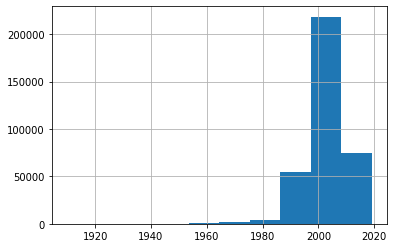

In [35]:
df['RegistrationYear'].hist()

Уже выглядит на много лучше, основные обявления распологаются в промежутке от 1980 до 2019 года, похоже на правду.

#### Gearbox

Тут все должно быть просто, всего 4 значения, автомат, механика, вариатор и пропуск, посмотрим.

In [36]:
df['Gearbox'].unique()

array(['manual', 'auto', nan], dtype=object)

Даже вариатора нету, ну ладно, посмотрим сколько пропусков.

In [37]:
df['Gearbox'].isna().sum()

19833

Почти 20к, много, думаем что можно сдлеать.

Посмотри сколько пропусков до 1950 года.

In [38]:
df.loc[df['RegistrationYear'] < 1950, 'Gearbox'].isna().sum()

129

Всего 129, мало, но лучше чем ничего. Эти пропуски точно можно заменить на механику, тк примерно с 50 года начали устанавливать АККП на автомобили.

In [39]:
df.loc[df['RegistrationYear'] < 1950, 'Gearbox'] = df.loc[df['RegistrationYear'] < 1950, 'Gearbox'].fillna('manual')

Удалять данные строки не хочется, большая потеря будет, можно тогда просто заменить на 'unknow'.

In [40]:
df['Gearbox'] = df['Gearbox'].fillna('unknown')

In [41]:
df['Gearbox'].isna().sum()

0

Ну и для успокоение, посмотрим рапределение.

<AxesSubplot:>

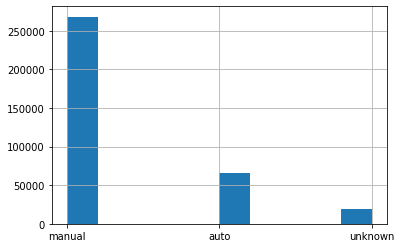

In [42]:
df['Gearbox'].hist()

Как и следовало ожидать, механики на рынке больше, чем автоматов, все как в жизни.

#### Power

Тут пропусков нет, но навернека есть аномалии, посмотрим.

<AxesSubplot:>

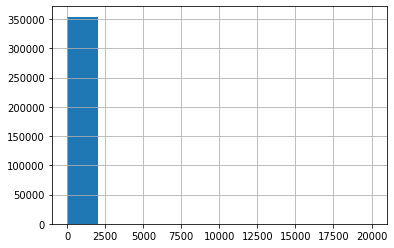

In [43]:
df['Power'].hist()

Не понятно. Сузим разброс. До 500 л.с. будет не плохо.

<AxesSubplot:>

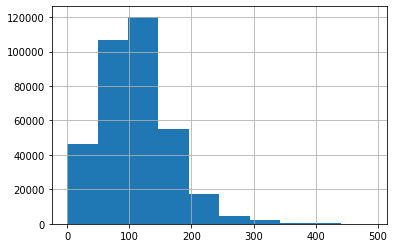

In [44]:
df.loc[df['Power'] < 500, 'Power'].hist()

На этом диапозоне все хорошо, посмотрим что творится за его приделами.

In [45]:
df.loc[df['Power'] > 500, 'Power'].count()

459

тут всего 459 объявлений, посмотрим какие есть значения.

In [46]:
df.loc[df['Power'] > 500, 'Power'].sort_values().unique()

array([  504,   505,   507,   508,   510,   514,   515,   517,   519,
         520,   521,   525,   530,   540,   541,   544,   550,   551,
         553,   560,   572,   574,   579,   580,   584,   585,   599,
         600,   601,   602,   603,   604,   606,   607,   610,   612,
         620,   640,   645,   650,   651,   671,   678,   682,   685,
         696,   700,   702,   703,   732,   743,   750,   751,   754,
         771,   776,   800,   805,   808,   850,   851,   871,   900,
         901,   902,   903,   907,   909,   923,   950,   952,   953,
         960,   998,   999,  1000,  1001,  1002,  1003,  1004,  1005,
        1011,  1012,  1016,  1017,  1021,  1024,  1054,  1055,  1056,
        1062,  1079,  1082,  1090,  1100,  1102,  1103,  1105,  1111,
        1115,  1120,  1149,  1151,  1158,  1160,  1162,  1164,  1199,
        1200,  1202,  1221,  1223,  1230,  1239,  1240,  1241,  1250,
        1252,  1256,  1275,  1288,  1299,  1300,  1312,  1317,  1324,
        1339,  1351,

По скольку даже формула 1 имеет на своем борту двигатель 600 л.с., а гипер кары имеют двигатели в районе 1000 л.с., думаю эти объявления явно имеют ошибки. По этому не видя здесь каких-то закономерностей просто удалим эти значения.

In [47]:
df = df.drop(index = df.loc[df['Power'] > 500].index).reset_index(drop=True)

<AxesSubplot:>

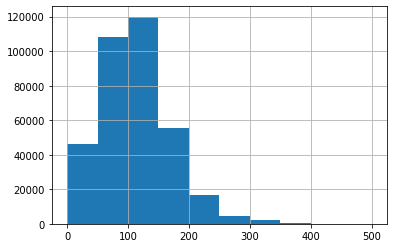

In [48]:
df['Power'].hist()

Еще вопрос к 0 значениям.

In [49]:
df.loc[df['Power'] == 0, 'Power'].count()

40225

Их так же достаточно много, постутпим как и с колонкой 'Price'.

#### Model

Тут очень много пропусков. Будем разбираться.

In [50]:
len(df['Model'].unique())

251

In [51]:
df['Model'].isna().sum()

19647

251 модель, думаю смотреть на их распределение нет смысла, будет не информативно. По сольку пропусков много, просто заменим их на "unknow", как и в других категориях.

In [52]:
df['Model'] = df['Model'].fillna('unknown')

In [53]:
df['Model'].isna().sum()

0

Еще можно посмотреть на 10 самых популярных моделей.

In [54]:
df['Model'].value_counts().head(10)

golf        29204
other       24379
3er         19743
unknown     19647
polo        13049
corsa       12555
astra       10794
passat      10133
a4           9893
c_klasse     8304
Name: Model, dtype: int64

Другие почти на ровне с лидеров "golf", возможно организаторам стоит расширить базу по моделям.

#### Kilometer

Тут также нет пропуском, но наврняка есть не логичные значения, посмотрим на распределение.

<AxesSubplot:>

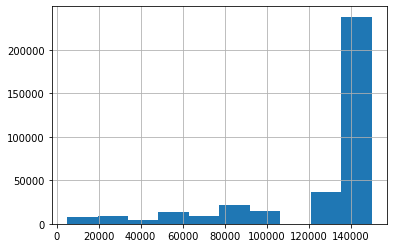

In [55]:
df['Kilometer'].hist()

Интересно, большое количство объявлений с пробугом больше 125к КМ, интересно почему.

In [56]:
df['Kilometer'].value_counts()

150000    237892
125000     36408
100000     14869
90000      11556
80000      10037
70000       8585
60000       7436
5000        6361
50000       6227
40000       4904
30000       4428
20000       3967
10000       1219
Name: Kilometer, dtype: int64

картина проясняется, видимо в форме объявления нельяз написать точный пробег, а можно только выбрать приблизительный. Так же видно что после 100к шаг увеличиватется, а поле 150к, возмоно, нельзя выбрать большее значение.

В любом случае сильно тут ничего не сделаешь.

#### RegistrationMonth

Пропусков нет, все здорово, можно только посмотеть в какой месяц чаще регестрировали машины. Логи подсказывает, что должно быть +- равномерно, но кто нает.

<AxesSubplot:ylabel='RegistrationMonth'>

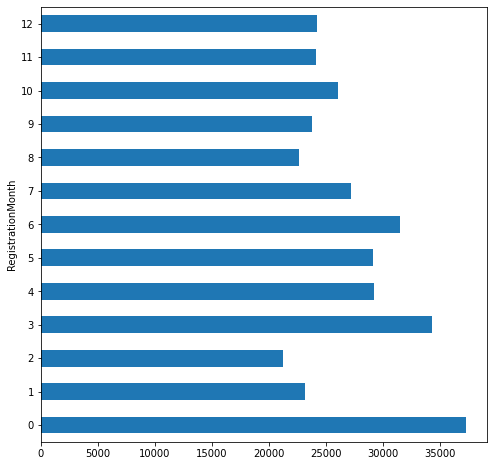

In [57]:
df.pivot_table(index = "RegistrationMonth",
               values = "Price",
               aggfunc = "count").plot(y = "Price", 
                                      kind = "barh", 
                                      legend = False,
                                      figsize = (8,8),
                                      ylabel = "")

In [58]:
df['RegistrationMonth'].value_counts()

0     37285
3     34338
6     31458
4     29236
5     29120
7     27182
10    26070
12    24241
11    24154
9     23782
1     23185
8     22601
2     21237
Name: RegistrationMonth, dtype: int64

Почти угадал, видим большой скачек после нового года, оно и очивидно, большенсвто салонов делают в этот период большую скидку. Дальше есть Март и Июнь, наверняка есть и тут свои закономерности, но они нм сильно не помогут. 

#### FuelType

Этот столбец имеет внушительное клоичество попусков.

In [59]:
df['FuelType'].isna().sum()

32797

In [60]:
df['FuelType'].value_counts()

petrol      216060
gasoline     98639
lpg           5305
cng            563
hybrid         233
other          203
electric        89
Name: FuelType, dtype: int64

Пропусков много, категорий тоже хватате. Поступим как и в других категориальных столбцах, "unknown" наш выбор.

In [61]:
df['FuelType'] = df['FuelType'].fillna('unknown')

Теперь есть еще один подготовленный столбец.

#### Brand 

Пропусков нет, можно просто оценить количество брендов и их распределение.

In [62]:
df['Brand'].value_counts()

volkswagen        76923
opel              39872
bmw               36865
mercedes_benz     31995
audi              29415
ford              25148
renault           17901
peugeot           10991
fiat               9627
seat               6896
mazda              5614
skoda              5496
smart              5239
citroen            5134
nissan             4933
toyota             4601
hyundai            3585
sonstige_autos     3364
volvo              3207
mini               3199
mitsubishi         3016
honda              2814
kia                2463
suzuki             2320
alfa_romeo         2312
chevrolet          1747
chrysler           1435
dacia               899
daihatsu            806
subaru              762
porsche             752
jeep                677
trabant             589
land_rover          545
daewoo              541
saab                526
jaguar              502
rover               486
lancia              467
lada                225
Name: Brand, dtype: int64

Брендов много, на удивление очень мало отечественных. Возможно заказчик инастраная платформа.

#### Repaired

Это самый бедный на информацию столбец.

In [63]:
df["Repaired"].isna().sum()

70993

In [64]:
f'Пропусков аж {((df["Repaired"].isna().sum()/len(df))*100).round(2)} %'

'Пропусков аж 20.06 %'

<AxesSubplot:>

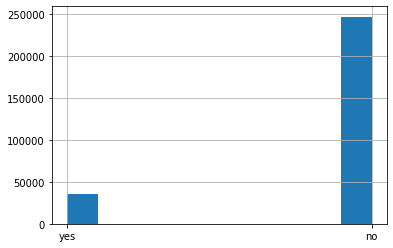

In [65]:
df['Repaired'].hist()

Как видно у нас прпусков бальше чем машин с ремонтом, терять 20% информации совсем не хочется, по этому выход есть "unknow".

In [66]:
df['Repaired'] = df['Repaired'].fillna('unknow')

Столбце готов к дальнейшей работе.

#### DateCreated

Тут все хорошо, как и с другим столбцом даты, просто переведем его в нужный формат.

In [67]:
df['DateCreated'] = pd.to_datetime(df['DateCreated'], format = '%Y-%m-%d %H:%M:%S')

In [68]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 353889 entries, 0 to 353888
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype         
---  ------             --------------   -----         
 0   DateCrawled        353889 non-null  datetime64[ns]
 1   Price              353889 non-null  int64         
 2   VehicleType        353889 non-null  object        
 3   RegistrationYear   353889 non-null  int64         
 4   Gearbox            353889 non-null  object        
 5   Power              353889 non-null  int64         
 6   Model              353889 non-null  object        
 7   Kilometer          353889 non-null  int64         
 8   RegistrationMonth  353889 non-null  int64         
 9   FuelType           353889 non-null  object        
 10  Brand              353889 non-null  object        
 11  Repaired           353889 non-null  object        
 12  DateCreated        353889 non-null  datetime64[ns]
 13  NumberOfPictures   353889 non-null  int64   

Здорово, идем дальше.

#### NumberOfPictures

Полный столбце, посмотрим как много фотографий пользователи добавляют

<AxesSubplot:>

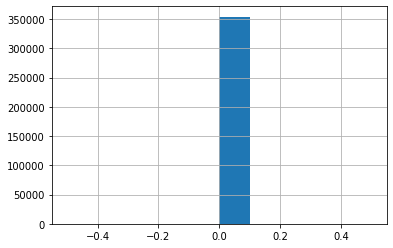

In [69]:
df['NumberOfPictures'].hist()

По графику в основном 0. 

In [70]:
df['NumberOfPictures'].describe()

count    353889.0
mean          0.0
std           0.0
min           0.0
25%           0.0
50%           0.0
75%           0.0
max           0.0
Name: NumberOfPictures, dtype: float64

Очень интересно, у всех объявлений нет фотографий. Тут нужно задать вопрос людям которые скачивали данные, столбце важный, а даных нет. Ну по скольку до этих людей нам не обраться, просто уберем этот не информативный столбец.

In [71]:
df = df.drop(['NumberOfPictures'], axis=1).reset_index(drop=True)

Вот и все с этим столбцом.

#### PostalCode

Тут столбец без пропуско и полный. Единственное что можно сделать откуда люди, чаще всего пубикуют объявления.

In [72]:
df['PostalCode'].value_counts()

10115    819
65428    613
66333    343
32257    317
44145    315
        ... 
26906      1
25868      1
6638       1
29487      1
31096      1
Name: PostalCode, Length: 8143, dtype: int64

Как подсказывает интерент 5и значные индексы использует Америка и Германия и еслипредположение верное, то больше всего обявлений из Нью-Йорка или Берлина. Учитывая подовляющее большинство немецких машин в объявлении, можно смело заявить что это Немецкая платформа.

#### LastSeen

Ничего нового, столбец с датой в нужный формат.

In [73]:
df['LastSeen'] = pd.to_datetime(df['LastSeen'], format = '%Y-%m-%d %H:%M:%S')

In [74]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 353889 entries, 0 to 353888
Data columns (total 15 columns):
 #   Column             Non-Null Count   Dtype         
---  ------             --------------   -----         
 0   DateCrawled        353889 non-null  datetime64[ns]
 1   Price              353889 non-null  int64         
 2   VehicleType        353889 non-null  object        
 3   RegistrationYear   353889 non-null  int64         
 4   Gearbox            353889 non-null  object        
 5   Power              353889 non-null  int64         
 6   Model              353889 non-null  object        
 7   Kilometer          353889 non-null  int64         
 8   RegistrationMonth  353889 non-null  int64         
 9   FuelType           353889 non-null  object        
 10  Brand              353889 non-null  object        
 11  Repaired           353889 non-null  object        
 12  DateCreated        353889 non-null  datetime64[ns]
 13  PostalCode         353889 non-null  int64   

Отлично, на этапе создания новых столбцов, возможно это пригодится.

### Новые столбцы

Еще раз посмотрим на то что у нас есть.

In [75]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 353889 entries, 0 to 353888
Data columns (total 15 columns):
 #   Column             Non-Null Count   Dtype         
---  ------             --------------   -----         
 0   DateCrawled        353889 non-null  datetime64[ns]
 1   Price              353889 non-null  int64         
 2   VehicleType        353889 non-null  object        
 3   RegistrationYear   353889 non-null  int64         
 4   Gearbox            353889 non-null  object        
 5   Power              353889 non-null  int64         
 6   Model              353889 non-null  object        
 7   Kilometer          353889 non-null  int64         
 8   RegistrationMonth  353889 non-null  int64         
 9   FuelType           353889 non-null  object        
 10  Brand              353889 non-null  object        
 11  Repaired           353889 non-null  object        
 12  DateCreated        353889 non-null  datetime64[ns]
 13  PostalCode         353889 non-null  int64   

In [76]:
df.sample(5, random_state=RANDOM_STATE)

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired,DateCreated,PostalCode,LastSeen
224563,2016-03-14 22:49:59,1450,convertible,2000,manual,95,megane,150000,3,petrol,renault,no,2016-03-14,24357,2016-03-21 18:46:50
321819,2016-04-07 02:36:21,5999,small,2008,unknown,61,fortwo,60000,12,petrol,smart,no,2016-04-07,12105,2016-04-07 02:36:21
315056,2016-03-23 20:56:18,999,convertible,1995,manual,90,unknown,150000,12,unknown,volkswagen,no,2016-03-23,44143,2016-04-06 02:46:12
342098,2016-04-07 09:06:34,7500,convertible,2000,auto,250,clk,150000,1,petrol,mercedes_benz,no,2016-04-07,57518,2016-04-07 09:25:24
209102,2016-03-09 12:48:15,0,unknow,2000,unknown,0,e_klasse,150000,0,unknown,mercedes_benz,unknow,2016-03-09,98693,2016-04-05 21:18:16


Кажется, что такие точные даты нам не нужны, по этому можно оставить по столбцу месяца и года для каждой даты.

In [77]:
for col in ['DateCrawled', 'DateCreated', 'LastSeen']:
    df[f'{col}Year']=pd.DatetimeIndex(df[col]).year
    df[f'{col}Month']=pd.DatetimeIndex(df[col]).month
        

In [78]:
df.sample(5, random_state=RANDOM_STATE)

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,...,Repaired,DateCreated,PostalCode,LastSeen,DateCrawledYear,DateCrawledMonth,DateCreatedYear,DateCreatedMonth,LastSeenYear,LastSeenMonth
224563,2016-03-14 22:49:59,1450,convertible,2000,manual,95,megane,150000,3,petrol,...,no,2016-03-14,24357,2016-03-21 18:46:50,2016,3,2016,3,2016,3
321819,2016-04-07 02:36:21,5999,small,2008,unknown,61,fortwo,60000,12,petrol,...,no,2016-04-07,12105,2016-04-07 02:36:21,2016,4,2016,4,2016,4
315056,2016-03-23 20:56:18,999,convertible,1995,manual,90,unknown,150000,12,unknown,...,no,2016-03-23,44143,2016-04-06 02:46:12,2016,3,2016,3,2016,4
342098,2016-04-07 09:06:34,7500,convertible,2000,auto,250,clk,150000,1,petrol,...,no,2016-04-07,57518,2016-04-07 09:25:24,2016,4,2016,4,2016,4
209102,2016-03-09 12:48:15,0,unknow,2000,unknown,0,e_klasse,150000,0,unknown,...,unknow,2016-03-09,98693,2016-04-05 21:18:16,2016,3,2016,3,2016,4


Отлично, необходимую информацию из этих столбцов мы получили, теперь их можно убрать.

In [79]:
df = df.drop(['DateCrawled', 'DateCreated', 'LastSeen'],axis=1).reset_index(drop=True)

In [80]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 353889 entries, 0 to 353888
Data columns (total 18 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   Price              353889 non-null  int64 
 1   VehicleType        353889 non-null  object
 2   RegistrationYear   353889 non-null  int64 
 3   Gearbox            353889 non-null  object
 4   Power              353889 non-null  int64 
 5   Model              353889 non-null  object
 6   Kilometer          353889 non-null  int64 
 7   RegistrationMonth  353889 non-null  int64 
 8   FuelType           353889 non-null  object
 9   Brand              353889 non-null  object
 10  Repaired           353889 non-null  object
 11  PostalCode         353889 non-null  int64 
 12  DateCrawledYear    353889 non-null  int64 
 13  DateCrawledMonth   353889 non-null  int64 
 14  DateCreatedYear    353889 non-null  int64 
 15  DateCreatedMonth   353889 non-null  int64 
 16  LastSeenYear       3

Больше вроде ничего создать не хочется, идем дальше.

### Unknow

Прежде чем переходить к обучению, можно еще подчистить нашу таблицу. Есть строки где 3 и больше категориальных признака отсутствуют. Думаю можно посотреть на их количество и оценить на сколько они нужны.

In [81]:
def unknow_count (df):
    count = 0
    if df['VehicleType'] == 'unknown': count += 1
    if df['Gearbox'] == 'unknown': count += 1
    if df['Model'] == 'unknown': count += 1
    if df['FuelType'] == 'unknown': count += 1
    if df['Brand'] == 'unknown': count += 1 
    if df['Repaired'] == 'unknown': count += 1
    if count >= 3: 
        return True
    else: return False

In [82]:
con_unk = df.apply(unknow_count, axis = 1)

In [83]:
con_unk.sum()

2853

Почти 3 тысячи строк с пропусками в категориальных переменных. Если в этих строрках еще и цена равна 0 тогда они точно не нужны.

In [84]:
len(df.loc[con_unk & (df['Price'] == 0)])

843

843 строки можно спокойно удалить.

In [85]:
df = df.drop(index = df.loc[con_unk & (df['Price'] == 0)].index, axis = 1).reset_index(drop=True)

В принципе тут все

### ОНЕ

По скольку будем использовать не только градиентный бустинг, но и линейную регресию, неоюходимо подготовить категориальные переменные, будем исползовать OHE.

Если использовать просто OHE, то получим таблицу с количеством столбцов за 300 шт, кажется это личшнее. Основную массу дополнительных столбцов добавляют колонки с моделью и маркой автомобиля, еще раз посмотрим на них.

In [86]:
df['Model'].value_counts()

golf                  29204
other                 24379
3er                   19743
unknown               18804
polo                  13049
                      ...  
i3                        8
serie_3                   4
rangerover                4
range_rover_evoque        2
serie_1                   2
Name: Model, Length: 251, dtype: int64

Думаю если мы оставим 70% всех модель, а остальные отнесем к категории "other" сильно ничего не потеряем.

In [87]:
df_ohe = df

In [88]:
models_count = df_ohe['Model'].value_counts()
leght = len(models_count)
models_sum = models_count.sum()
for i in range(leght):
    if models_count[:i+1].sum()/models_sum > .7: 
        break
i

29

Получается, 29 моделей составляют 70% от всех объявлений, для красивого чилса оставим 30 самых полпулярных.

In [89]:
model_70 = df['Model'].value_counts().head(30).index
model_70

Index(['golf', 'other', '3er', 'unknown', 'polo', 'corsa', 'astra', 'passat',
       'a4', 'c_klasse', '5er', 'e_klasse', 'a3', 'focus', 'fiesta', 'a6',
       'twingo', '2_reihe', 'transporter', 'fortwo', 'vectra', 'a_klasse',
       'mondeo', 'clio', '1er', '3_reihe', 'touran', 'punto', 'zafira',
       'megane'],
      dtype='object')

In [90]:
def distribution_of_models (df):
    if df["Model"] not in model_70:
        df["Model"] = "other"
    return df

In [91]:
df_ohe = df_ohe.apply(distribution_of_models, axis = 1)

In [92]:
df_ohe['Model'].value_counts()

other          128420
golf            29204
3er             19743
unknown         18804
polo            13049
corsa           12555
astra           10794
passat          10133
a4               9893
c_klasse         8304
5er              7856
e_klasse         6769
a3               6118
focus            5867
fiesta           5769
a6               5535
twingo           4945
2_reihe          4815
transporter      4813
fortwo           4334
vectra           4241
a_klasse         4188
mondeo           3597
clio             3543
1er              3512
3_reihe          3490
touran           3466
punto            3342
zafira           3038
megane           2909
Name: Model, dtype: int64

Теперь конечно категория другие встала на первое место, посмотрим как это скажтесяс на моделе.

Столбце марок.

In [93]:
len(df_ohe['Brand'].value_counts())

40

В принципе их получилось чуть больше чем моделей, остваим как есть.

In [94]:
df_ohe = pd.get_dummies(df_ohe, drop_first= True)

In [95]:
df_ohe.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 353046 entries, 0 to 353045
Data columns (total 99 columns):
 #   Column                   Non-Null Count   Dtype
---  ------                   --------------   -----
 0   Price                    353046 non-null  int64
 1   RegistrationYear         353046 non-null  int64
 2   Power                    353046 non-null  int64
 3   Kilometer                353046 non-null  int64
 4   RegistrationMonth        353046 non-null  int64
 5   PostalCode               353046 non-null  int64
 6   DateCrawledYear          353046 non-null  int64
 7   DateCrawledMonth         353046 non-null  int64
 8   DateCreatedYear          353046 non-null  int64
 9   DateCreatedMonth         353046 non-null  int64
 10  LastSeenYear             353046 non-null  int64
 11  LastSeenMonth            353046 non-null  int64
 12  VehicleType_convertible  353046 non-null  uint8
 13  VehicleType_coupe        353046 non-null  uint8
 14  VehicleType_other        353046 non-

100 столбцов, думаю не плохо.

### 0 значения

По скольку некоторые важные значения имеют 0, можно создать отдельные таблице без этих строк.

In [96]:
df_zeroless = df.loc[
    (df['Price'] != 0) &
    (df['Power'] != 0)
]

In [97]:
len(df) - len(df_zeroless)

46259

Ушло 46к строк, весомое значение, интересно как скажется на результате.

In [98]:
df_ohe_zeroless = df_ohe.loc[
    (df_ohe['Price'] != 0) &
    (df_ohe['Power'] != 0)
]

Теперь вроде бы все готово для подготовки к обучению

### Фичи и ответы

Теперь нуобходимо разделить фичи и ответы, а так же выборки на тестовую и тренировочную.

In [99]:
train_df, test_df = train_test_split(df, test_size=.25, random_state=RANDOM_STATE)
train_df_zeroless, test_df_zeroless = train_test_split(df_zeroless, test_size=.25, random_state=RANDOM_STATE)
train_df_ohe, test_df_ohe = train_test_split(df_ohe, test_size=.25, random_state=RANDOM_STATE)
train_df_ohe_zeroless, test_df_ohe_zeroless = train_test_split(df_ohe_zeroless, test_size=.25, random_state=RANDOM_STATE)

In [100]:
train_df_features = train_df.drop(["Price"], axis= 1)
train_df_ans = train_df["Price"]
test_df_features = test_df.drop(["Price"], axis= 1)
test_df_ans = test_df["Price"]

train_df_zeroless_features = train_df_zeroless.drop(["Price"], axis= 1)
train_df_zeroless_ans = train_df_zeroless["Price"]
test_df_zeroless_features = test_df_zeroless.drop(["Price"], axis= 1)
test_df_zeroless_ans = test_df_zeroless["Price"]

train_df_ohe_features = train_df_ohe.drop(["Price"], axis= 1)
train_df_ohe_ans = train_df_ohe["Price"]
test_df_ohe_features = test_df_ohe.drop(["Price"], axis= 1)
test_df_ohe_ans = test_df_ohe["Price"]

train_df_ohe_zeroless_features = train_df_ohe_zeroless.drop(["Price"], axis= 1)
train_df_ohe_zerolesss_ans = train_df_ohe_zeroless["Price"]
test_df_ohe_zeroless_features = test_df_ohe_zeroless.drop(["Price"], axis= 1)
test_df_ohe_zeroless_ans = test_df_ohe_zeroless["Price"]

## Обучение моделей

Возьмем три модели для обучения, это "лес", регресию, CatBoost и LightGBM

### Лес

Поскольку у нас есть `GridSearchCV` то нам понаобятся только тестовая и тернировочная выборки.

Для леса важен масштаб, по этому применяем `StandardScaler`. Для леса будем использовать выборки с ОНЕ.

In [101]:
column = train_df_ohe_features.columns
scaler = StandardScaler()
scaler.fit(train_df_ohe_features[column])
pd.options.mode.chained_assignment = None

In [102]:
train_df_ohe_features[column] = scaler.transform(train_df_ohe_features[column])
test_df_ohe_features[column] = scaler.transform(test_df_ohe_features[column])

In [103]:
column = train_df_ohe_zeroless_features.columns
scaler = StandardScaler()
scaler.fit(train_df_ohe_zeroless_features[column])
pd.options.mode.chained_assignment = None

In [104]:
train_df_ohe_zeroless_features[column] = scaler.transform(train_df_ohe_zeroless_features[column])
test_df_ohe_zeroless_features[column] = scaler.transform(test_df_ohe_zeroless_features[column])

In [181]:
%%time
parametrs = {'n_estimators' : range(250,851,200),
            'max_depth' :[8,9],
            'min_samples_leaf' : [6],
            'min_samples_split': [2]}
rfr = GridSearchCV(RFR(random_state= RANDOM_STATE), 
                   parametrs, 
                   scoring = 'neg_root_mean_squared_error', 
                   verbose = 3,
                   cv=2)
rfr.fit(train_df_ohe_features, train_df_ohe_ans)
print (rfr.best_params_)
print (rfr.best_score_)
bot_send(f'{rfr.best_score_}')
for s in rfr.best_params_:
    bot_send (f'{s}: {rfr.best_params_[s]}')

Fitting 2 folds for each of 8 candidates, totalling 16 fits
[CV 1/2] END max_depth=8, min_samples_leaf=6, min_samples_split=2, n_estimators=250; total time= 2.7min
[CV 2/2] END max_depth=8, min_samples_leaf=6, min_samples_split=2, n_estimators=250; total time= 2.7min
[CV 1/2] END max_depth=8, min_samples_leaf=6, min_samples_split=2, n_estimators=450; total time= 4.8min
[CV 2/2] END max_depth=8, min_samples_leaf=6, min_samples_split=2, n_estimators=450; total time= 5.0min
[CV 1/2] END max_depth=8, min_samples_leaf=6, min_samples_split=2, n_estimators=650; total time= 7.2min
[CV 2/2] END max_depth=8, min_samples_leaf=6, min_samples_split=2, n_estimators=650; total time= 7.3min
[CV 1/2] END max_depth=8, min_samples_leaf=6, min_samples_split=2, n_estimators=850; total time= 9.4min
[CV 2/2] END max_depth=8, min_samples_leaf=6, min_samples_split=2, n_estimators=850; total time= 9.3min
[CV 1/2] END max_depth=9, min_samples_leaf=6, min_samples_split=2, n_estimators=250; total time= 2.9min
[CV 

In [184]:
MSE(test_df_ohe_ans, rfr.predict(test_df_ohe_features),squared=False)

2102.3263639487545

In [182]:
%%time
parametrs = {'n_estimators' : range(250,851,200),
            'max_depth' : [8,9],
            'min_samples_leaf' : [2],
            'min_samples_split': [2]}
rfr_zr = GridSearchCV(RFR(random_state= RANDOM_STATE), 
                   parametrs, 
                   scoring = 'neg_root_mean_squared_error', 
                   verbose = 3,
                   cv=2)
rfr_zr.fit(train_df_ohe_zeroless_features, train_df_ohe_zerolesss_ans)
print (rfr_zr.best_params_)
print (rfr_zr.best_score_)
bot_send(f'{rfr_zr.best_score_}')
for s in rfr_zr.best_params_:
    bot_send (f'{s}: {rfr_zr.best_params_[s]}')

Fitting 2 folds for each of 8 candidates, totalling 16 fits
[CV 1/2] END max_depth=8, min_samples_leaf=2, min_samples_split=2, n_estimators=250; total time= 2.3min
[CV 2/2] END max_depth=8, min_samples_leaf=2, min_samples_split=2, n_estimators=250; total time= 2.2min
[CV 1/2] END max_depth=8, min_samples_leaf=2, min_samples_split=2, n_estimators=450; total time= 3.9min
[CV 2/2] END max_depth=8, min_samples_leaf=2, min_samples_split=2, n_estimators=450; total time= 4.0min
[CV 1/2] END max_depth=8, min_samples_leaf=2, min_samples_split=2, n_estimators=650; total time= 5.7min
[CV 2/2] END max_depth=8, min_samples_leaf=2, min_samples_split=2, n_estimators=650; total time= 5.7min
[CV 1/2] END max_depth=8, min_samples_leaf=2, min_samples_split=2, n_estimators=850; total time= 7.4min
[CV 2/2] END max_depth=8, min_samples_leaf=2, min_samples_split=2, n_estimators=850; total time= 7.6min
[CV 1/2] END max_depth=9, min_samples_leaf=2, min_samples_split=2, n_estimators=250; total time= 2.5min
[CV 

In [183]:
MSE(test_df_ohe_zeroless_ans, rfr_zr.predict(test_df_ohe_zeroless_features),squared=False)

1973.7453518512411

После парочки прогонов гиперпараметров для леса, видно что лес с набором даных без нулей показывает лучшую метрику, по этому дальше будем подбирать параметры только для него.

In [198]:
%%time 
parametrs = {'n_estimators' : range(650, 851, 100),
            'max_depth' : [9],
            'min_samples_leaf' : [2],
            'min_samples_split': [2]}
rfr_zr = GridSearchCV(RFR(random_state= RANDOM_STATE), 
                   parametrs, 
                   scoring = 'neg_root_mean_squared_error', 
                   verbose = 3,
                   cv=2)
rfr_zr.fit(train_df_ohe_zeroless_features, train_df_ohe_zerolesss_ans)
print (rfr_zr.best_params_)
print (rfr_zr.best_score_)
bot_send(f'{rfr_zr.best_score_}')
for s in rfr_zr.best_params_:
    bot_send (f'{s}: {rfr_zr.best_params_[s]}')

Fitting 2 folds for each of 3 candidates, totalling 6 fits
[CV 1/2] END max_depth=9, min_samples_leaf=2, min_samples_split=2, n_estimators=650; total time= 6.5min
[CV 2/2] END max_depth=9, min_samples_leaf=2, min_samples_split=2, n_estimators=650; total time= 6.6min
[CV 1/2] END max_depth=9, min_samples_leaf=2, min_samples_split=2, n_estimators=750; total time= 7.5min
[CV 2/2] END max_depth=9, min_samples_leaf=2, min_samples_split=2, n_estimators=750; total time= 7.6min
[CV 1/2] END max_depth=9, min_samples_leaf=2, min_samples_split=2, n_estimators=850; total time= 8.6min
[CV 2/2] END max_depth=9, min_samples_leaf=2, min_samples_split=2, n_estimators=850; total time= 8.6min
{'max_depth': 9, 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 850}
-1972.5981326447863
3862.7343225479126
CPU times: user 1h 4min 12s, sys: 5.65 s, total: 1h 4min 18s
Wall time: 1h 4min 22s


In [194]:
MSE(test_df_ohe_zeroless_ans, rfr_zr.predict(test_df_ohe_zeroless_features),squared=False)

1973.7453518512411

Перебрав гиперпараметры получили RMSE на тестовой выборке 1973,8. Не плохой результат, теперь посмотрим на вермя обучения для этих параметров и времени предсказания.

In [105]:
start = time()
rfr_zr = RFR(random_state= RANDOM_STATE,
             max_depth=9,
             min_samples_leaf=2,
             min_samples_split=2,
             n_estimators=850)
rfr_zr.fit(train_df_ohe_zeroless_features, train_df_ohe_zerolesss_ans)
time_rfr_fit = time()-start

In [ ]:
start = time()
rfr_zr_predict = rfr_zr.predict(test_df_ohe_zeroless_features)
time_rfr_pre = time()-start

In [ ]:
rmse_rfr = MSE(test_df_ohe_zeroless_ans, rfr_zr_predict,squared=False)

NameError: name 'rfr_zr_predict' is not defined

In [ ]:
display(f'время обучения {time_rfr_fit}')
display(f'время предсказания {time_rfr_pre}')
display(f'RMSE {rmse_rfr}')

'время обучения 1121.989134311676'

'время предсказания 5.382678985595703'

Получили необхлжимые данные, потом собирем все в единую таблицу и будем принимать решение.

### LinearRegression

Тут все просто, пармаетров нету, просто обучаем и радуемся быстрым результатам.

In [ ]:
start = time()
lr = LR()
lr.fit(train_df_ohe_features, train_df_ohe_ans)
time_lr_fit = time()-start
strat= time()
lr_predict = lr.predict(test_df_ohe_features)
time_lr_pre = time() - start
rmse_lr = MSE(test_df_ohe_ans, lr_predict,squared=False)

In [ ]:
start = time()
lr_zr = LR()
lr_zr.fit(train_df_ohe_zeroless_features, train_df_ohe_zerolesss_ans)
time_lr_zr_fit = time()-start
strat= time()
lr_zr_predict = lr_zr.predict(test_df_ohe_zeroless_features)
time_lr_zr_pre = time() - start
rmse_lr_zr = MSE(test_df_ohe_zeroless_ans, lr_zr_predict,squared=False)

In [ ]:
display('данные с нулями')
display(f'время обучения {time_lr_fit}')
display(f'время предсказания {time_lr_pre}')
display(f'RMSE {rmse_lr}')
display()
display('данные без нулей')
display(f'время обучения {time_lr_zr_fit}')
display(f'время предсказания {time_lr_zr_pre}')
display(f'RMSE {rmse_lr_zr}')

'данные с нулями'

'время обучения 6.89294958114624'

'время предсказания 7.085282325744629'

'RMSE 2896.840666791341'

'данные без нулей'

'время обучения 5.55510139465332'

'время предсказания 5.774473667144775'

'RMSE 2685.6759921596727'

Как видно во втором случае модель показала лучше результаты, и по вермени и по ошибке, но все-равно не прошла порога в 2500.

### CatBoost

По скольку CatBoost умеет радотать с категориальными величинами будем использовать для него df без OHE.

In [119]:
%%time
parametrs = {'depth' : range(10,15,1),
            'iterations' : range(800,1201,100),
            'learning_rate' : [0.8,.9,1],
            'l2_leaf_reg': range(2,5)}
cbr = GridSearchCV(CBR(random_seed= RANDOM_STATE,
                       logging_level='Silent',
                       cat_features = (['VehicleType',
                                        'Gearbox',
                                        'Model',
                                        'FuelType',
                                        'Brand',
                                        'Repaired'])), 
                   parametrs, 
                   scoring = 'neg_root_mean_squared_error',
                   verbose = 3,
                   cv=2)
cbr.fit(train_df_features, train_df_ans)
print (cbr.best_params_)
print (cbr.best_score_)
bot_send(f'{cbr.best_score_}')
for s in cbr.best_params_:
    bot_send (f'{s}: {cbr.best_params_[s]}')

Fitting 2 folds for each of 225 candidates, totalling 450 fits
[CV 1/2] END depth=10, iterations=800, l2_leaf_reg=2, learning_rate=0.8; total time= 5.1min
[CV 2/2] END depth=10, iterations=800, l2_leaf_reg=2, learning_rate=0.8; total time= 5.0min
[CV 1/2] END depth=10, iterations=800, l2_leaf_reg=2, learning_rate=0.9; total time= 4.9min
[CV 2/2] END depth=10, iterations=800, l2_leaf_reg=2, learning_rate=0.9; total time= 4.9min
[CV 1/2] END depth=10, iterations=800, l2_leaf_reg=2, learning_rate=1; total time= 4.9min
[CV 2/2] END depth=10, iterations=800, l2_leaf_reg=2, learning_rate=1; total time= 4.8min
[CV 1/2] END depth=10, iterations=800, l2_leaf_reg=3, learning_rate=0.8; total time= 4.8min
[CV 2/2] END depth=10, iterations=800, l2_leaf_reg=3, learning_rate=0.8; total time= 4.9min
[CV 1/2] END depth=10, iterations=800, l2_leaf_reg=3, learning_rate=0.9; total time= 4.8min
[CV 2/2] END depth=10, iterations=800, l2_leaf_reg=3, learning_rate=0.9; total time= 4.8min
[CV 1/2] END depth=10

KeyboardInterrupt: 

In [118]:
MSE(test_df_ans, cbr.predict(test_df_features),squared=False)

1661.0111043637169

## Анализ моделей

## Чек-лист проверки

Поставьте 'x' в выполненных пунктах. Далее нажмите Shift+Enter.

- [x]  Jupyter Notebook открыт
- [ ]  Весь код выполняется без ошибок
- [ ]  Ячейки с кодом расположены в порядке исполнения
- [ ]  Выполнена загрузка и подготовка данных
- [ ]  Выполнено обучение моделей
- [ ]  Есть анализ скорости работы и качества моделей